In [51]:

%pip install torchvision
%pip install numpy
%pip install matplotlib
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
%pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement google-colab (from versions: none)
ERROR: No matching distribution found for google-colab


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

In [20]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  [0.229, 0.224, 0.225])
    ]), 
}

data_dir = 'Pytorch/data/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0")

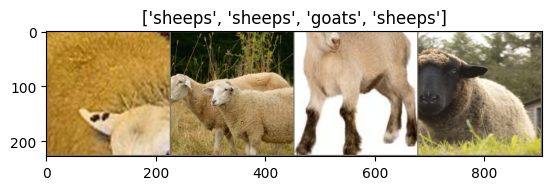

In [21]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoint
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs-1}')
            print('-' * 10)

            # Each epoch has a training and valiadtion phase
            for phase in ['train', 'val']:
                if phase == 'train' :
                    model.train() # Set model to training
                else:
                    model.eval() # set model to evaluate

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    #forward
                    #track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds  = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f' {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [23]:
# Visualizing the model predict

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [24]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [25]:
import torch; print(torch.cuda.is_available())

True


In [26]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
 train Loss: 0.5515 Acc: 0.7592
 val Loss: 0.4503 Acc: 0.8348

Epoch 1/24
----------
 train Loss: 0.5740 Acc: 0.7729
 val Loss: 0.2826 Acc: 0.8849

Epoch 2/24
----------
 train Loss: 0.5755 Acc: 0.7772
 val Loss: 0.3417 Acc: 0.8617

Epoch 3/24
----------
 train Loss: 0.4537 Acc: 0.8202
 val Loss: 0.3913 Acc: 0.8745

Epoch 4/24
----------
 train Loss: 0.4808 Acc: 0.8070
 val Loss: 0.5137 Acc: 0.7969

Epoch 5/24
----------
 train Loss: 0.4082 Acc: 0.8411
 val Loss: 0.2531 Acc: 0.9134

Epoch 6/24
----------
 train Loss: 0.4461 Acc: 0.8269
 val Loss: 0.2509 Acc: 0.8954

Epoch 7/24
----------
 train Loss: 0.3344 Acc: 0.8600
 val Loss: 0.2392 Acc: 0.9081

Epoch 8/24
----------
 train Loss: 0.3059 Acc: 0.8761
 val Loss: 0.2561 Acc: 0.9029

Epoch 9/24
----------
 train Loss: 0.2745 Acc: 0.8855
 val Loss: 0.1956 Acc: 0.9285

Epoch 10/24
----------
 train Loss: 0.2971 Acc: 0.8822
 val Loss: 0.2015 Acc: 0.9299

Epoch 11/24
----------
 train Loss: 0.2785 Acc: 0.8841
 val Loss

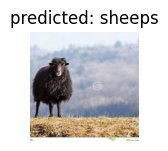

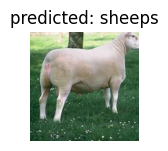

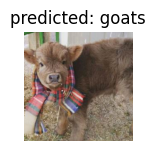

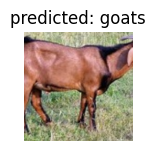

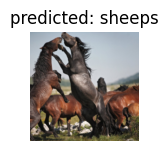

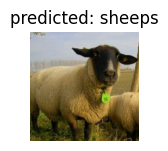

In [27]:
visualize_model(model_ft)

In [28]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=true by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [29]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
 train Loss: 0.5490 Acc: 0.7550
 val Loss: 0.3454 Acc: 0.8532

Epoch 1/24
----------
 train Loss: 0.4910 Acc: 0.7999
 val Loss: 0.2554 Acc: 0.8996

Epoch 2/24
----------
 train Loss: 0.4872 Acc: 0.8132
 val Loss: 0.2922 Acc: 0.8873

Epoch 3/24
----------
 train Loss: 0.4753 Acc: 0.8089
 val Loss: 0.3005 Acc: 0.8755

Epoch 4/24
----------
 train Loss: 0.4800 Acc: 0.8103
 val Loss: 0.2664 Acc: 0.9034

Epoch 5/24
----------
 train Loss: 0.5930 Acc: 0.7815
 val Loss: 0.2702 Acc: 0.8935

Epoch 6/24
----------
 train Loss: 0.5575 Acc: 0.7725
 val Loss: 0.3086 Acc: 0.8883

Epoch 7/24
----------
 train Loss: 0.4041 Acc: 0.8344
 val Loss: 0.2606 Acc: 0.9020

Epoch 8/24
----------
 train Loss: 0.4270 Acc: 0.8146
 val Loss: 0.2916 Acc: 0.8883

Epoch 9/24
----------
 train Loss: 0.3994 Acc: 0.8373
 val Loss: 0.2929 Acc: 0.8854

Epoch 10/24
----------
 train Loss: 0.3912 Acc: 0.8420
 val Loss: 0.2681 Acc: 0.8892

Epoch 11/24
----------
 train Loss: 0.3796 Acc: 0.8368
 val Loss

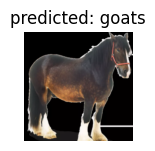

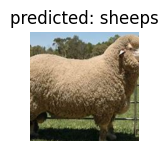

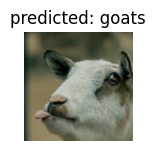

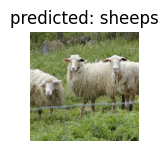

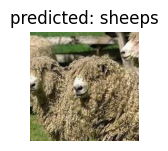

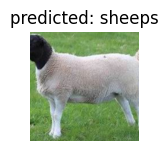

In [30]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [31]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


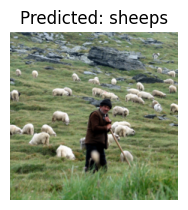

In [42]:
visualize_model_predictions(
    model_conv,
    img_path='Pytorch/data/dataset/testing/gembala.jpg'
)

plt.ioff()
plt.show()

In [46]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Fungsi untuk memproses gambar yang diunggah
def process_uploaded_image(change):
    uploaded = change['new']
    if uploaded is not None:
        img_bytes = uploaded['content']
        # Simpan gambar ke dalam file sementara (opsional)
        # temp_path = 'uploaded_image.jpg'
        # with open(temp_path, 'wb') as f:
        #     f.write(img_bytes)
        # img_path = temp_path

        # Proses gambar menggunakan model Anda (ganti dengan kode yang sesuai)
        # ...

        # Visualisasikan hasil prediksi
        visualize_model_predictions(model_conv, img_bytes)  # Atau gunakan img_path jika disimpan

# Widget untuk mengunggah file
upload = widgets.FileUpload()
display(upload)

# Hubungkan widget dengan fungsi pemroses
upload.observe(process_uploaded_image, names='data')



plt.ioff()
plt.show()



FileUpload(value=(), description='Upload')

In [52]:
import io

def visualize_model_predictions(model, img_bytes):
    # ... (kode untuk memproses gambar dan mendapatkan prediksi)
    predicted_class = ...  # Ganti dengan hasil prediksi model

    # Load gambar
    img = plt.imread(io.BytesIO(img_bytes))

    # Tampilkan gambar dengan label prediksi
    plt.imshow(img)
    plt.title(f"Predicted class: {predicted_class}")
    plt.axis('off')
    plt.show()